In [808]:
%matplotlib inline
import pandas as pd
import uproot
import awkward
import matplotlib.pyplot as plt
import numpy as np
import glob
from matplotlib.colors import LogNorm
import uproot_methods
from tqdm.auto import tqdm
import time

from utils import (
    set_plotting_style, get_chunking, make_df, hist2d_dask, query_dis,
    dataframe_to_ttree, ttree_to_dataframe
)
import utils

from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da
from dask import delayed
from yahist import Hist1D, Hist2D

In [809]:
set_plotting_style()

In [841]:
def subdf(df):
    sstr = "pass_baseline_extra_iso"
    sstr += f" and (abs(Muon1_dxyCorr/(lxy*{massname}/dimuon_pt)) > 0.1)"
    sstr += f" and (abs(Muon2_dxyCorr/(lxy*{massname}/dimuon_pt)) > 0.1)"
    sstr += f" and (abs(Muon1_dxyCorr/Muon1_dxyError) > 2.0)"
    sstr += f" and (abs(Muon2_dxyCorr/Muon2_dxyError) > 2.0)"
    cols = ["dimuon_massCorr","lxy","dimuon_pt"]
    if "Muon1_genMatch_motherct" in df.columns:
        cols += ["Muon1_genMatch_motherct"]
    return df[df.eval(sstr)][cols]

In [811]:
cut = "pass_baseline_extra_iso"
branches = ["dimuon_mass","dimuon_massCorr","dimuon_pt","logabsetaphi",
            "Muon*_dxy*","/pass_(baseline_extra_iso|genmatch)/","lxy",
            "minabsdxy",
#             "Muon*_trk_qoverp*",
#             "Muon*_pt",
           ]

df_data = utils.ttree_to_dataframe("data_unblind10ifb.root", branches=branches)
df_data = df_data[df_data[cut]]

# df_data = utils.ttree_to_dataframe("data_unblind10ifb_nodxyerrcut.root", branches=branches)
# df_data = df_data[df_data[cut]]
# df_data = df_data[df_data["logabsetaphi"]<1.25] # for v16 and earlier ntuples, _extra_iso branch missing this



In [812]:
df_data = subdf(df_data)

In [813]:
df_data["scale1fb"] = 1.

In [118]:
dfs_mc = dict()
# fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/*ctau*mm_BABY_v18/*.root")
ver = "v22"
fnames_mc = sum(map(glob.glob,[
    f"/hadoop/cms/store/user/namin/ProjectMetis/BToPhi*ctau*mm_BABY_{ver}/*.root",
    f"/hadoop/cms/store/user/namin/ProjectMetis/GGPhi*ctau*mm_BABY_{ver}/*.root",
    f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd15*ctau10mm_BABY_{ver}/*.root",
    f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd2_*ctau10mm_BABY_{ver}/*.root",
    f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd8*ctau10mm_BABY_{ver}/*.root",
    f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd8*ctau1mm_BABY_{ver}/*.root",
    f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd8*ctau50mm_BABY_{ver}/*.root",
]),[])
print(fnames_mc)
for fname_mc in fnames_mc:
    df_mc = make_df(
        fname_mc,
        branches = branches,
        cut = cut,
        chunksize = 400e3,
        use_dask = False,
        progress = False,
    )
    name = fname_mc.rsplit("/",2)[-2].split("params_")[1].split("_BABY")[0]
    if "phi" in name.lower():
        if "btophi" in fname_mc.lower():
            name = "btophi_"+name
        else:
            name = "ggphi_"+name
#     df_mc = df_mc[df_mc["logabsetaphi"]<1.25] # for v16 and earlier ntuples, _extra_iso branch missing this
    dfs_mc[name] = subdf(df_mc)

['/hadoop/cms/store/user/namin/ProjectMetis/BToPhi_params_mphi2_ctau20mm_BABY_v22/output_1.root', '/hadoop/cms/store/user/namin/ProjectMetis/BToPhi_params_mphi2_ctau20mm_BABY_v22/output_2.root', '/hadoop/cms/store/user/namin/ProjectMetis/BToPhi_params_mphi2_ctau20mm_BABY_v22/output_3.root', '/hadoop/cms/store/user/namin/ProjectMetis/BToPhi_params_mphi2_ctau20mm_BABY_v22/output_4.root', '/hadoop/cms/store/user/namin/ProjectMetis/GGPhiToMuMu_params_mphi2_ctau0p5mm_BABY_v22/output_1.root', '/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd15_ctau10mm_BABY_v22/output_1.root', '/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd2_ctau10mm_BABY_v22/output_1.root', '/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd8_ctau10mm_BABY_v22/output_1.root', '/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd8_ctau1mm_BABY_v22/output_1.root', '/hadoop/cms/store/user/namin/ProjectMetis/HToZdZdTo2Mu2X_params_mzd8_ctau50mm_BABY_v22/outp

In [21]:
def make_plot(h_datas, h_sigs, ax=None, legend_kwargs=dict(), **kwargs):
    if ax is None:
        ax = plt.gca()

    if type(h_datas) not in [list, tuple]:
        h_datas = [h_datas]
        
    if type(h_sigs) not in [list, tuple]:
        h_sigs = [h_sigs]
        
    for h_data, color in zip(h_datas, ["black","blue","red","green"]):
        h_data.plot(ax=ax,color=color,show_errors=True,markersize=kwargs.get("markersize",2.5));
                             
    for h_sig in h_sigs:
        h_sig.plot(ax=ax,histtype="step",linestyle="-");
                             
    ax.text(0.99, 1.01,"10.1 fb${}^\mathregular{-1}$", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size="large")

    if kwargs.get("logx"):
        ax.set_xscale("log")

    if kwargs.get("logy"):
        ax.set_yscale("log")

    ax.set_xlabel(kwargs.get("xlabel",""),horizontalalignment="right",x=1.)
    ax.set_ylabel(kwargs.get("ylabel",""),horizontalalignment="right",y=1.)
    ax.set_title(kwargs.get("title",""))

    ax.legend(**legend_kwargs)

    close = False
    if close:
        plt.close()

In [22]:
def plot_in_bins(func, bins, lxyedges, xlabel="", title="title", one=False, **kwargs):
#     fig, axs = plt.subplots(2,3, figsize=(18,10), sharex=True)
    if one:
        fig, ax = plt.subplots()
        axs = np.array([ax])
    else:
        fig, axs = plt.subplots(2,3, figsize=(18,10))
    for ax in axs.flat: ax.axis("off")
    for ax,lxylow,lxyhigh in zip(axs.flat,lxyedges[:-1],lxyedges[1:]):
        ax.axis("on")
        bins_ = bins
        if kwargs.get("secondary_bins") and lxylow < 0.01:
            bins_ = kwargs["secondary_bins"]

        isinlxy = (df_data.lxy > lxylow) & (df_data.lxy < lxyhigh)
        highmass = (df_data.dimuon_mass > 5)
        lowmass = (df_data.dimuon_mass < 5)
        h_datas_raw = [
            Hist1D(func(df_data[isinlxy & lowmass]), bins=bins_, label="Data (mass$<$5GeV)"),
            Hist1D(func(df_data[isinlxy & highmass]), bins=bins_, label="Data (mass$>$5GeV)"),
        ]
        h_mcs_raw = [
            Hist1D(func(v[(v.lxy > lxylow) & (v.lxy < lxyhigh)]), bins=bins_, label=k)
            for k,v in dfs_mc.items()
        ]
        h_mcs = []
        for h_mc in h_mcs_raw:
            h_mc._metadata["label"] += " (N={})".format(int(h_mc.integral))
            h_mcs.append(h_mc.normalize())
        h_datas = []
        for h_data in h_datas_raw:
            h_data._metadata["label"] += " (N={})".format(int(h_data.integral))
            h_datas.append(h_data.normalize())

        lxystr = r" [{}<$\rho$<{}]".format(lxylow,lxyhigh)

        make_plot(h_datas,h_mcs, 
                  ax = ax,
                  title=title+lxystr,
#                   ylabel="Fraction of events",
                  legend_kwargs=dict(loc="upper center"),
                  **kwargs,
                 )
        if kwargs.get("logy"):
            ax.set_yscale("log")
    ax = axs.flat[0]
    ax.set_ylabel("Fraction of events")
    ax = axs.flat[0 if one else 3]
    ax.set_xlabel(xlabel)
    fig.set_tight_layout(True)

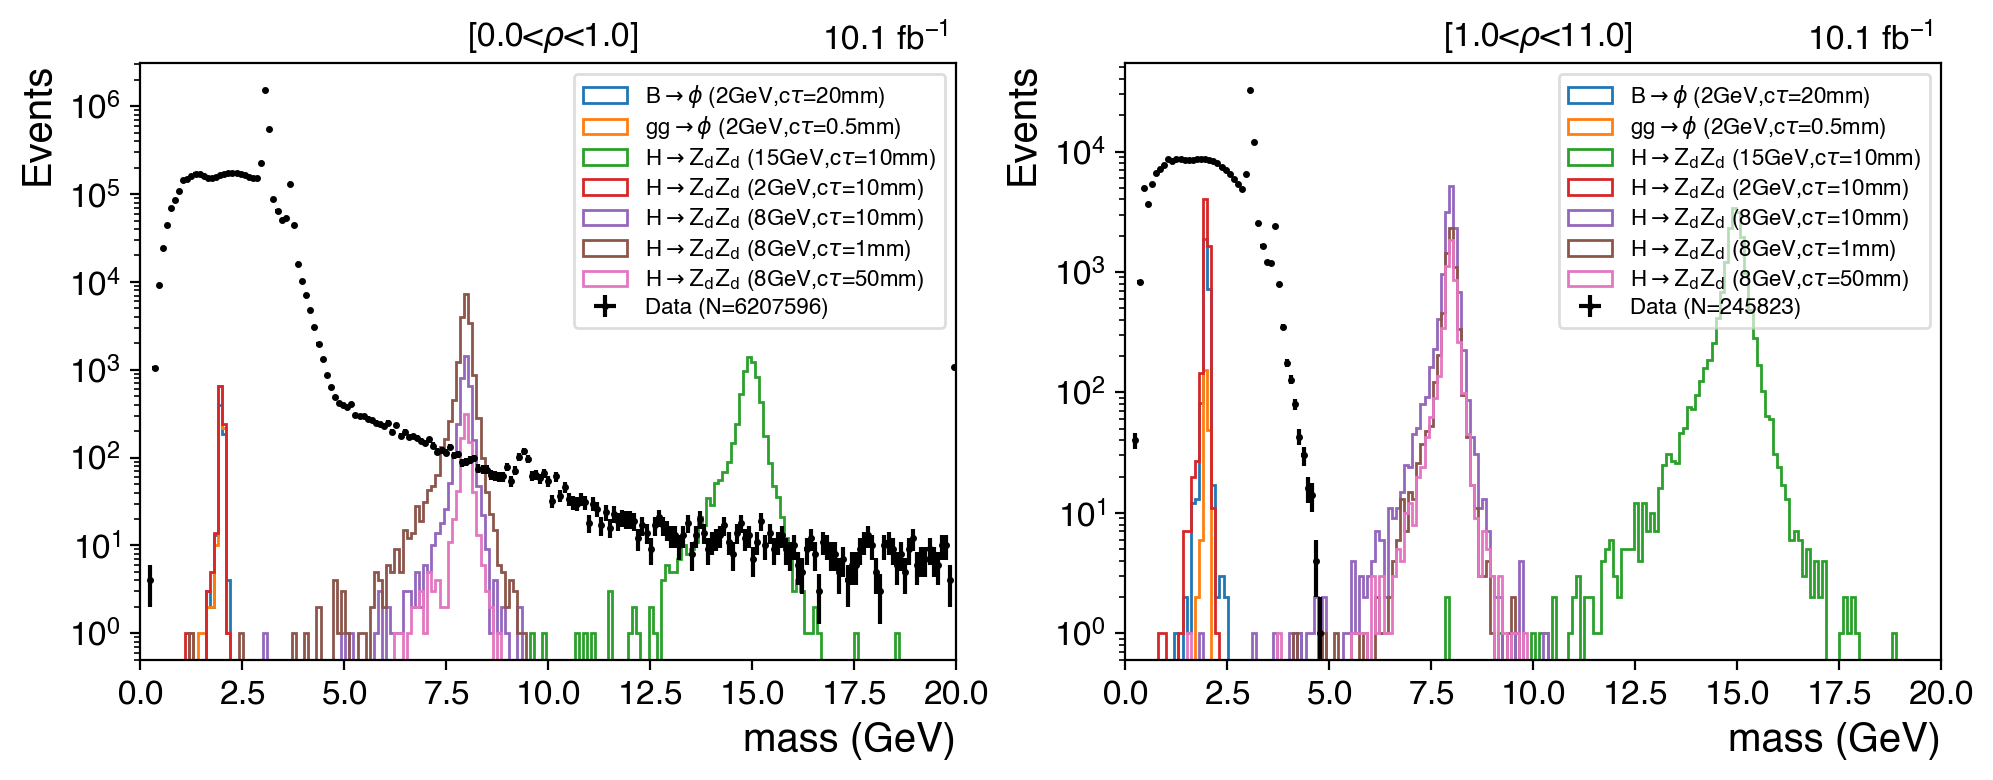

In [71]:
# lxyedges = np.array([0, 1.0, 2.4, 3.1, 7.0, 11.0])
lxyedges = np.array([0, 1.0, 11.])
bins = np.linspace(0, 20, 200)
title = ""
xlabel = "mass (GeV)"
massname = "dimuon_massCorr"

labelmap = {
    "btophi_mphi2_ctau20mm": r"B$\rightarrow\phi$ (2GeV,c$\tau$=20mm)",
    "ggphi_mphi2_ctau0p5mm": r"gg$\rightarrow\phi$ (2GeV,c$\tau$=0.5mm)",
    "mzd15_ctau10mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (15GeV,c$\tau$=10mm)",
    "mzd2_ctau10mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (2GeV,c$\tau$=10mm)",
    "mzd8_ctau10mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=10mm)",
    "mzd8_ctau1mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=1mm)",
    "mzd8_ctau50mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=50mm)",
    
}

def select(df, lxylow, lxyhigh):
    sstr = f"{lxylow} < lxy < {lxyhigh}"
    sstr += f" and (abs(Muon1_dxyCorr/(lxy*{massname}/dimuon_pt)) > 0.1)"
    sstr += f" and (abs(Muon2_dxyCorr/(lxy*{massname}/dimuon_pt)) > 0.1)"
    sstr += f" and (abs(Muon1_dxyCorr/Muon1_dxyError) > 2.0)"
    sstr += f" and (abs(Muon2_dxyCorr/Muon2_dxyError) > 2.0)"
    return df[df.eval(sstr)]
# fig, axs = plt.subplots(3,2, figsize=(10,12))
fig, axs = plt.subplots(1,2, figsize=(10,4))
# fig, ax = plt.subplots()
# axs = np.array([ax])
for ax in axs.flat: ax.axis("off")
    
for ax,lxylow,lxyhigh in zip(axs.flat,lxyedges[:-1],lxyedges[1:]):
    ax.axis("on")
    bins_ = bins

    h_data = Hist1D(select(df_data, lxylow, lxyhigh).eval(massname), bins=bins)

    sf = 1.0
    h_mcs = [
        sf*Hist1D(select(df, lxylow, lxyhigh).eval(massname), bins=bins,label=labelmap[label]) 
        for label,df in dfs_mc.items()
    ]
    h_data._metadata["label"] = "Data (N={})".format(int(h_data.integral))

    lxystr = r" [{}<$\rho$<{}]".format(lxylow,lxyhigh)

    make_plot(h_data,h_mcs, 
              ax = ax,
              title=title+lxystr,
              xlabel=xlabel,
              ylabel="Events",
              logy=True,
              markersize=1.5,
              legend_kwargs=dict(loc="upper right", fontsize=8))
fig.set_tight_layout(True)

In [297]:
# dfs_mc.keys()
labelmap = {
    "btophi_mphi2_ctau20mm": r"B$\rightarrow\phi$ (2GeV,c$\tau$=20mm)",
    "ggphi_mphi2_ctau0p5mm": r"gg$\rightarrow\phi$ (2GeV,c$\tau$=0.5mm)",
    "mzd15_ctau10mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (15GeV,c$\tau$=10mm)",
    "mzd2_ctau10mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (2GeV,c$\tau$=10mm)",
    "mzd8_ctau10mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=10mm)",
    "mzd8_ctau1mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=1mm)",
    "mzd8_ctau50mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (8GeV,c$\tau$=50mm)",
    "mzd2_ctau1mm": r"H$\rightarrow \mathrm{Z_d Z_d}$ (2GeV,c$\tau$=1mm)",
    
}


In [ ]:

# list(map(labelmap.__getitem__,dfs_mc.keys()))
list(map(lambda x: x.plot(), [
    Hist1D(df["dimuon_massCorr"], bins="50,0,20", label=labelmap[label]) 
    for label,df in dfs_mc.items()
]));
plt.gca().legend()

In [ ]:

dfs_mc = dict()
# fnames_mc = glob.glob("/hadoop/cms/store/user/namin/ProjectMetis/*ctau*mm_BABY_v18/*.root")
ver = "v22"
fnames_mc = sum(map(glob.glob,[
    f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd*ctau*mm_BABY_{ver}/*.root",
]),[])
print(fnames_mc)
for fname_mc in fnames_mc:
    df_mc = make_df(
        fname_mc,
        branches = branches,
        cut = cut,
        chunksize = 400e3,
        use_dask = False,
        progress = False,
    )
    name = fname_mc.rsplit("/",2)[-2].split("params_")[1].split("_BABY")[0]
    if "phi" in name.lower():
        if "btophi" in fname_mc.lower():
            name = "btophi_"+name
        else:
            name = "ggphi_"+name
#     df_mc = df_mc[df_mc["logabsetaphi"]<1.25] # for v16 and earlier ntuples, _extra_iso branch missing this
    dfs_mc[name] = df_mc

In [126]:
df_data["weight"] = 1.

In [1044]:

lumi = 10.1
# ver = "v22"
ver = "vtest2ctau"
# ver = "vtest3ctau"
samples = glob.glob(f"/hadoop/cms/store/user/namin/ProjectMetis/HToZd*mzd*ctau*mm_BABY_{ver}/")
dfs_mc = {}
for sample in tqdm(samples):
    fnames = glob.glob(f"{sample}/*.root")
    df_mc = make_df(
        fnames,
#         branches = branches,
        branches = list(set(branches)-set(["dimuon_massCorr"]))+["dimuon_mass","Muon1_genMatch_motherct"],
        cut = cut,
        chunksize = 400e3,
        use_dask = False,
        progress = False,
    )
    name = fnames[0].rsplit("/",2)[-2].split("params_")[1].split("_BABY")[0]
    df_mc = df_mc.rename({"dimuon_mass":"dimuon_massCorr"},axis=1)
    df = subdf(df_mc)
    nevents_in = sum(uproot.open(fname)["nevents_input"]._fVal for fname in fnames)
    xsec = 10 # in fb-1
    # Leff = N/xsec; scale1fb = 1ifb/Leff
    df["scale1fb"] = 1.0*xsec/nevents_in
    df["weight"] = lumi*df["scale1fb"]
    df["xsec"] = xsec
    dfs_mc[name] = df

In [1045]:
def mass_ctau_df(dfs_mc):
    temp = []
    for k in dfs_mc.keys():
        m = k.split("mzd")[1].split("_")[0]
        ctau = k.split("ctau")[1].split("mm")[0]
        temp.append(dict(name=k, m=float(m), ctau=float(ctau)))
    return pd.DataFrame(temp)
    
masses = mass_ctau_df(dfs_mc)["m"].unique().astype(int)

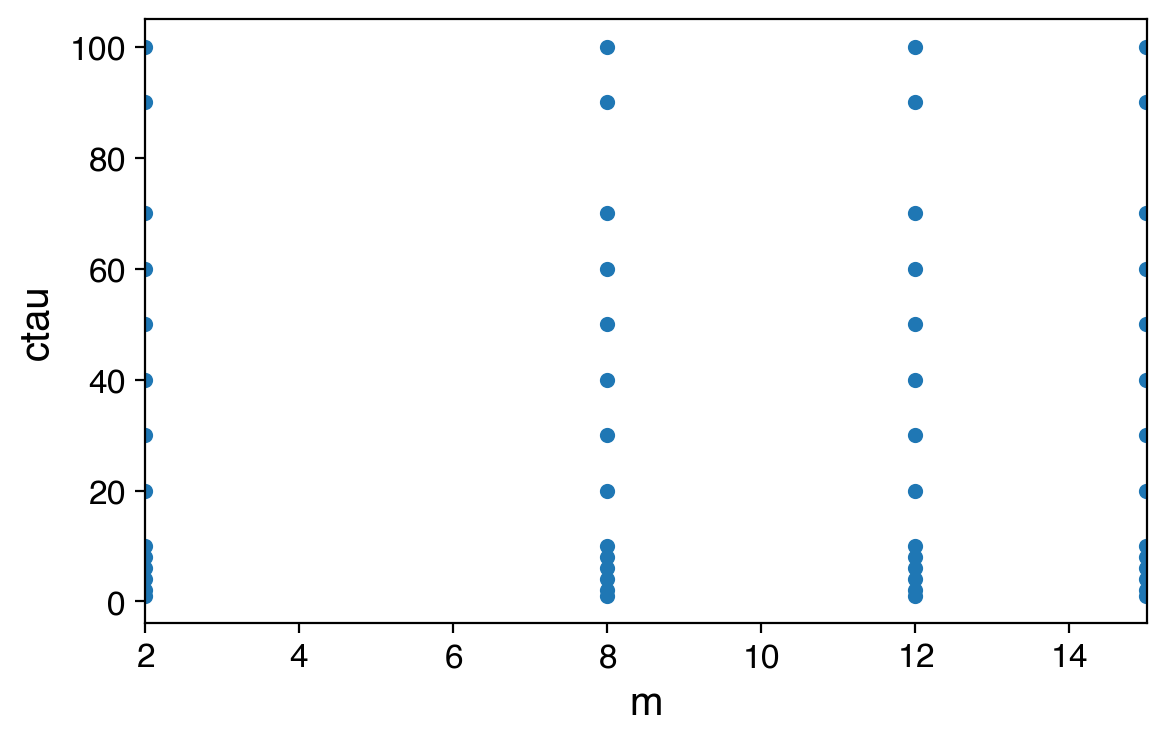

In [1046]:
def reweight_df(df0, ctau0, ctau1):
    w = (ctau0/ctau1) * np.exp(10.*df0["Muon1_genMatch_motherct"]/ctau0 - 10.*df0["Muon1_genMatch_motherct"]/ctau1)
    df1 = df0.copy()
    df1["weight"] *= w
    return df1

for mass in masses:
    for ctau0, ctau1 in ([
        [100, 90],
        [100, 70],
        [100, 60],
        [50, 40],
        [50, 30],
        [50, 20],
        [10, 8],
        [10, 6],
        [10, 4],
        [10, 2],
    ]):
        dfs_mc[f"mzd{mass}_ctau{ctau1}mm"] = reweight_df(dfs_mc[f"mzd{mass}_ctau{ctau0}mm"], ctau0, ctau1)

fig, ax = plt.subplots()
mass_ctau_df(dfs_mc).plot.scatter(ax=ax,x="m",y="ctau")

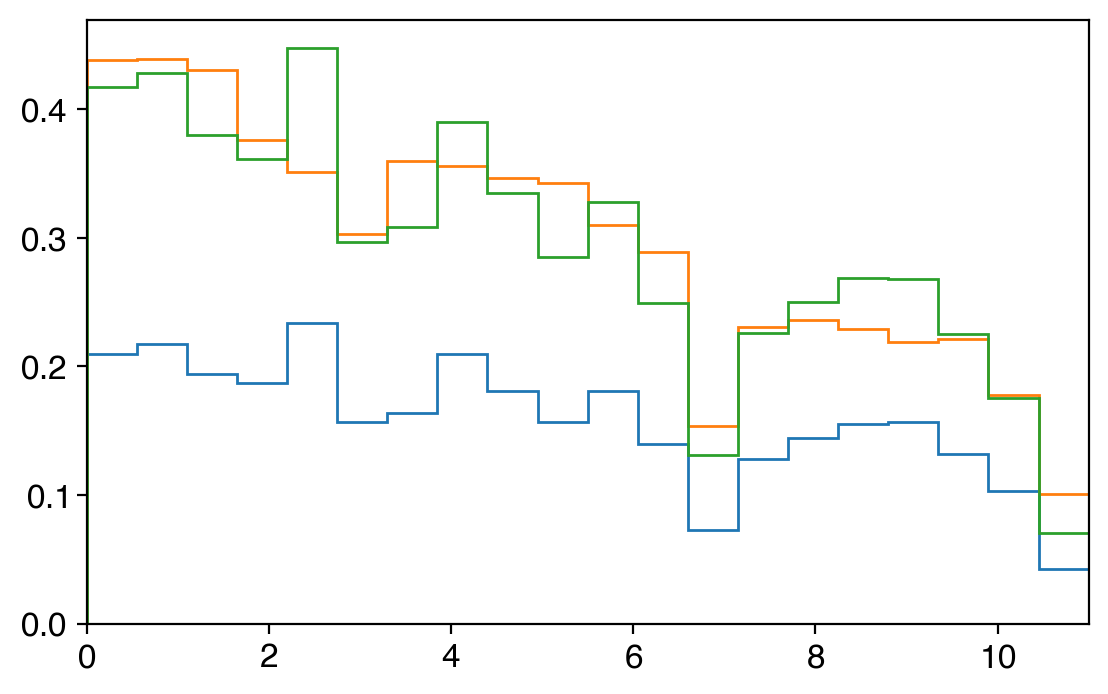

In [1047]:
df = dfs_mc["mzd8_ctau100mm"]
Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step")

df = dfs_mc["mzd8_ctau50mm"]
Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step")

df = reweight_df(dfs_mc["mzd8_ctau100mm"], 100, 50)
Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step")

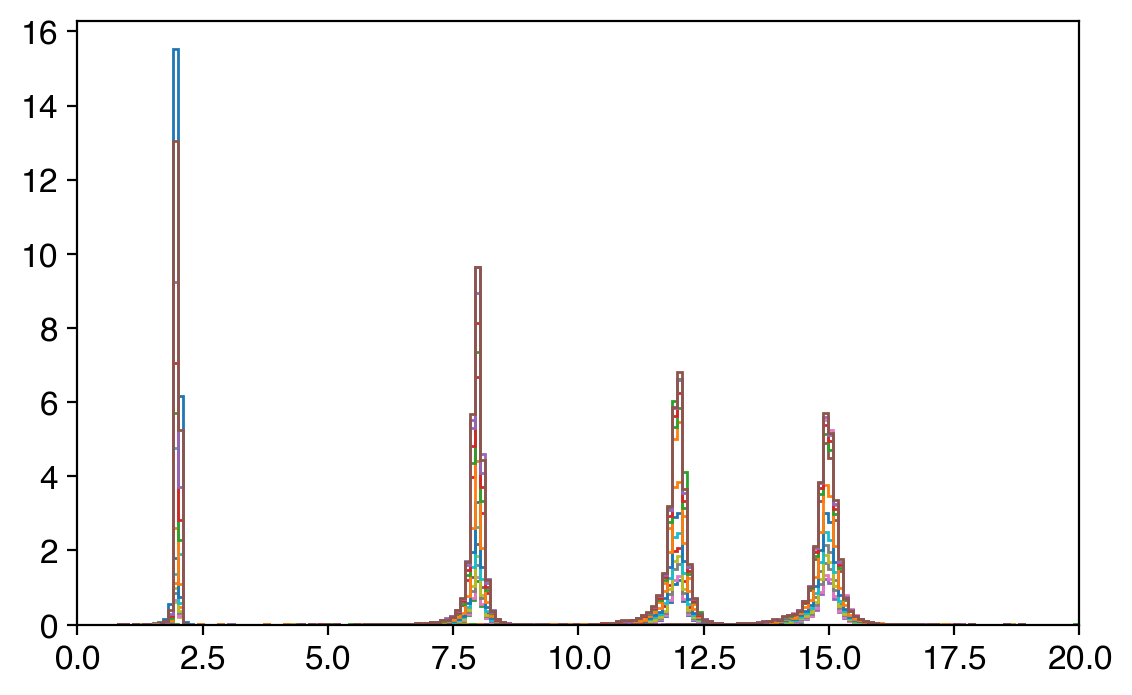

In [1048]:
bins = np.linspace(0,20,200)
lumi = 10.1
fig, ax = plt.subplots()
def fsel(df, rholow=0.,rhohigh=11.):
    return df[(df["lxy"] > rholow) & (df["lxy"] < rhohigh)]
# rholow = 1.
rholow = 0.
rhohigh = 11.
for k,df in dfs_mc.items():
    df = fsel(df,rholow,rhohigh)
    h = Hist1D(df["dimuon_massCorr"], bins=bins, weights=df["weight"], label=k)
    h.plot(histtype="step")
# ax.legend()

In [1049]:
def run_limits(v_sigsr=[1.0], v_obssr=[0], v_obssb=[0], v_tf=[0.5], xsec=None):
    # returns r value UL unless xsec is not None, then it multiplies rUL by xsec to get xsecUL
    import subprocess
    ncards = len(v_sigsr)
    fnames = []
    for i,(sigsr,obssr,obssb,tf) in enumerate(zip(v_sigsr,v_obssr,v_obssb,v_tf)):
        fname = f"temp_card_{i}.txt"
        fnames.append(fname)
        with open(fname,"w") as fh:
            fh.write(f"""
imax 1
jmax *
kmax *
------------
bin bin1
observation {obssr}
------------
bin             bin1 bin1
process         sig  bg
process          0     1
rate           {sigsr}  {tf*obssb}
------------
normsigtot    lnN    1.15   -
normsig{i}    lnN    1.05   -
normbg{i} lnN -    1.05
sb{i} gmN {obssb}    -   {tf}
            """)
    with open("temp_script.sh","w") as fh:
        fh.write(f"""
source /cvmfs/cms.cern.ch/cmsset_default.sh
cd ../limits/CMSSW_8_1_0
cmsenv
cd -
combineCards.py {" ".join(fnames)} > temp_card.txt
combine -M Asymptotic temp_card.txt
        """)
    out = subprocess.getoutput("source ./temp_script.sh")
    temp = {}
    for line in out.splitlines():
        if line.startswith("Observed Limit:"):
            val = float(line.rsplit("<")[-1])
            if xsec is not None:
                val *= xsec
            temp["obs"] = val
        if line.startswith("Expected "):
            val = float(line.rsplit("<")[-1])
            if xsec is not None:
                val *= xsec
            label = line.split("%")[0]
            temp["_".join(label.split()).replace("Expected","exp")] = val
    return temp



In [985]:
counts = get_counts(8, 50)

v_sigsr = counts["v_sigsr"]
v_obssr = counts["v_obssr"]
v_obssb = counts["v_obssb"]
v_tf = counts["v_tf"]
sname = counts["sname"]
xsec = counts["xsec"]

lims = run_limits(v_sigsr, v_obssr, v_obssb, v_tf, xsec=xsec)
print(lims)

{'obs': 4.226, 'exp_2.5': 1.197, 'exp_16.0': 2.14, 'exp_50.0': 4.141, 'exp_84.0': 8.234, 'exp_97.5': 12.557}


In [987]:
counts = get_counts(8, 50)

v_sigsr = counts["v_sigsr"]
v_obssr = counts["v_obssr"]
v_obssb = counts["v_obssb"]
v_tf = counts["v_tf"]
sname = counts["sname"]
xsec = counts["xsec"]

lims = run_limits(v_sigsr, v_obssr, v_obssb, v_tf, xsec=xsec)
print(lims)

{'obs': 4.148, 'exp_2.5': 1.186, 'exp_16.0': 2.12, 'exp_50.0': 4.102, 'exp_84.0': 8.058, 'exp_97.5': 12.438}


In [871]:
ctaus

array([100,  10,   1,  50,  90,  70,  60,  40,  30,  20,   8,   6,   4,
         2])

In [959]:
fracsrmass = 0.05
def mc_rho_bin_yield(mass, ctau, rholow, rhohigh):
    sname = f"mzd{mass}_ctau{ctau}mm"
    if sname in dfs_mc:
        srmasslow = mass*(1-fracsrmass)
        srmasshigh = mass*(1+fracsrmass)
        sigsr = dfs_mc[sname][dfs_mc[sname].eval(f"{rholow}<lxy<{rhohigh} and {srmasslow}<dimuon_massCorr<{srmasshigh}")]["weight"].sum()
        xsec = dfs_mc[sname]["xsec"].mean()
    else:
        masses = np.unique(np.array([int(x.split("mzd",1)[1].split("_",1)[0]) for x in dfs_mc.keys()]))
        mass1 = masses[masses < mass].max() # next lowest mass
        mass2 = masses[masses > mass].min() # next highest mass
        
        sname = f"mzd{mass1}_ctau{ctau}mm"
        srmasslow = mass1*(1-fracsrmass)
        srmasshigh = mass1*(1+fracsrmass)
        sigsr1 = dfs_mc[sname][dfs_mc[sname].eval(f"{rholow}<lxy<{rhohigh} and {srmasslow}<dimuon_massCorr<{srmasshigh}")]["weight"].sum()
        xsec = dfs_mc[sname]["xsec"].mean()
        
        sname = f"mzd{mass2}_ctau{ctau}mm"
        srmasslow = mass2*(1-fracsrmass)
        srmasshigh = mass2*(1+fracsrmass)
        sigsr2 = dfs_mc[sname][dfs_mc[sname].eval(f"{rholow}<lxy<{rhohigh} and {srmasslow}<dimuon_massCorr<{srmasshigh}")]["weight"].sum()
        
        dx = (mass - mass1)/(mass2 - mass1)
        sigsr = sigsr1 + (sigsr2-sigsr1)*dx
#         print(mass, ctau, sigsr1, sigsr2)
    return sigsr, xsec
        
def get_counts(mass, ctau):
    lxyedges = np.array([0, 0.2, 1.0, 2.4, 3.1, 7.0, 11.0])
    sname = f"mzd{mass}_ctau{ctau}mm"
    v_obssr = []
    v_sigsr = []
    v_obssb = []
    v_tf = []
    for rholow, rhohigh in zip(lxyedges[:-1],lxyedges[1:]):
        srmasslow = mass*(1-fracsrmass)
        srmasshigh = mass*(1+fracsrmass)
        sbmasslow = mass*(1-fracsrmass*3)
        sbmasshigh = mass*(1+fracsrmass*3)

        obssr = df_data.eval(f"{rholow}<lxy<{rhohigh} and {srmasslow}<dimuon_massCorr<{srmasshigh}").sum()
        sigsr, xsec = mc_rho_bin_yield(mass, ctau, rholow, rhohigh)
        obssblow = df_data.eval(f"{rholow}<lxy<{rhohigh} and {sbmasslow}<dimuon_massCorr<{srmasslow}").sum()
        obssbhigh = df_data.eval(f"{rholow}<lxy<{rhohigh} and {srmasshigh}<dimuon_massCorr<{sbmasshigh}").sum()

        # transfer factor (=SRwidth/sidebandwidth) to multiplyu by SB observation to get SR bkg pred
        tf = (srmasshigh-srmasslow)/((sbmasshigh-srmasshigh)+(srmasslow-sbmasslow))
        v_obssr.append(obssr)
        v_sigsr.append(sigsr)
        v_obssb.append(obssblow+obssbhigh)
        v_tf.append(tf)
    return dict(
        sname = sname,
        xsec = xsec,
        v_obssr = v_obssr,
        v_sigsr = v_sigsr,
        v_obssb = v_obssb,
        v_tf = v_tf,
    )
temp = []

masses = mass_ctau_df(dfs_mc)["m"].astype(int).unique()
ctaus = mass_ctau_df(dfs_mc)["ctau"].astype(int).unique()

# masses = [8]

# masses = [13]
# ctaus = [100]

masses = [2,4,6,8,10,12,15]

for mass in tqdm(masses):
    for ctau in tqdm(ctaus):
        
        counts = get_counts(mass, ctau)
        
        v_sigsr = counts["v_sigsr"]
#         v_sigsrerr = counts["v_sigsrerr"]
        v_obssr = counts["v_obssr"]
        v_obssb = counts["v_obssb"]
        v_tf = counts["v_tf"]
        sname = counts["sname"]
        xsec = counts["xsec"]
            
        try:
            lims = run_limits(v_sigsr, v_obssr, v_obssb, v_tf, xsec=xsec)
            lims.update(
                name=sname,
                mass=mass,
                ctau=ctau,
            )
            temp.append(lims)
        except:
            print(f"ERROR with {sname}")
            continue

df_lims = pd.DataFrame(temp).set_index("name")
df_lims

,obs,exp_2.5,exp_16.0,exp_50.0,exp_84.0,exp_97.5,mass,ctau
name,,,,,,,,
mzd2_ctau100mm,209.271,105.176,148.013,224.375,358.530,558.352,2,100
mzd2_ctau10mm,30.433,15.161,21.336,32.344,51.424,80.388,2,10
mzd2_ctau1mm,41.851,20.226,27.888,41.094,62.879,94.162,2,1
mzd2_ctau50mm,112.168,56.250,78.662,120.000,190.792,298.251,2,50
mzd2_ctau90mm,189.164,95.215,133.152,203.125,324.575,505.472,2,90
...,...,...,...,...,...,...,...,...
mzd15_ctau20mm,1.492,0.415,0.736,1.416,2.759,4.294,15,20
mzd15_ctau8mm,1.241,0.350,0.611,1.147,2.181,3.479,15,8
mzd15_ctau6mm,1.270,0.362,0.623,1.157,2.172,3.508,15,6


[0.48581 3.02899 4.03798 1.41299 5.37926 2.35532]
[1.2079397  5.22560804 6.28636181 1.98853266 6.04375879 1.62615075]
[0.91751807 4.25903614 5.41992771 1.76810843 6.20845783 2.00539759]
[0.89845554 4.28420031 5.32276961 1.74187152 5.7589736  1.93865186]


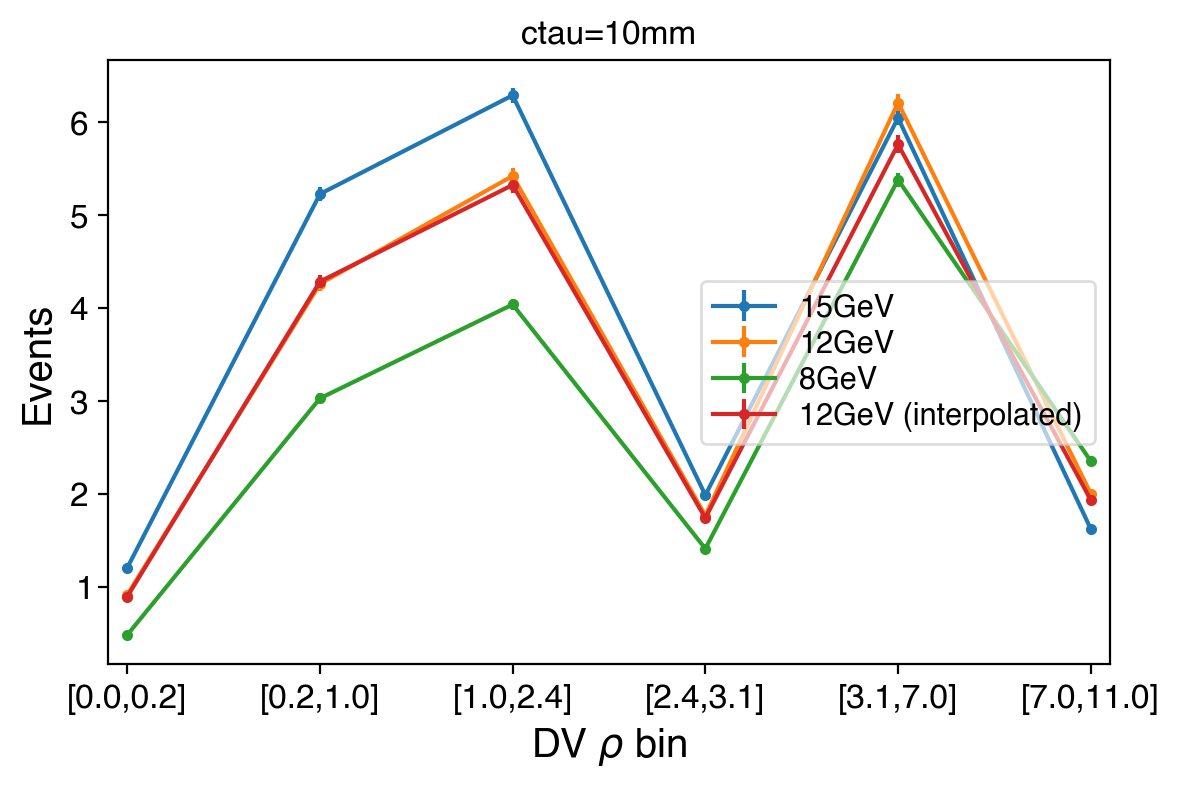

In [1069]:
ctau = 10
# v15 = np.array(get_counts(15, ctau)["v_sigsr"])
# v12 = np.array(get_counts(12, ctau)["v_sigsr"])
# v8 = np.array(get_counts(8, ctau)["v_sigsr"])

lxyedges = np.array([0.,0.2,1.,2.4,3.1,7.0,11.])
fig, ax = plt.subplots()
def get_ce(m):
    df = dfs_mc[f"mzd{m}_ctau{ctau}mm"].query(f"0.95*{m}<dimuon_massCorr<1.05*{m}")
    h = Hist1D(df["lxy"], bins=lxyedges, weights=df["weight"], label=f"{m}GeV")
    h._edges = np.arange(len(h._edges))
    return h
#     return h.counts, h.errors


h15 = get_ce(15)
h12 = get_ce(12)
h8 = get_ce(8)
v15,v15err = h15.counts, h15.errors
v12,v12err = h12.counts, h12.errors
v8,v8err = h8.counts, h8.errors

h = h8+(h15-h8)/(15-8)*(12-8)
v12interp,v12interperr = h.counts, h.errors


# v15err = np.array(get_counts(15, ctau)["v_sigsrerr"])
# v12err = np.array(get_counts(12, ctau)["v_sigsrerr"])
# v8err = np.array(get_counts(8, ctau)["v_sigsrerr"])
print(v8)
print(v15)
print(v12)
print(v12interp)
def f(mout, vlow, vhigh, mlow, mhigh):
    if mlow > mhigh:
        vlow, vhigh = vhigh, vlow
        mlow, mhigh = mhigh, mlow
    dx = (mout - mlow)/(mhigh - mlow)
    vout = vlow + (vhigh-vlow)*dx
    return vout
    
plt.title(f"ctau={ctau}mm")
xs = np.arange(len(v15))
# v12interp = f(12, v15,v8,15,8)
plt.errorbar(xs, v15, yerr=v15err, label="15GeV", marker=".")
plt.errorbar(xs, v12, yerr=v12err, label="12GeV", marker=".")
plt.errorbar(xs, v8, yerr=v8err, label="8GeV", marker=".")
plt.errorbar(xs, v12interp, yerr=v12interperr, label="12GeV (interpolated)", marker=".")

xlims = plt.gca().get_xlim()
plt.xlim(xlims[0]-0.1, xlims[-1]+0.1)

plt.legend()
plt.xticks(
    np.arange(6),
    [
        "[0.0,0.2]",
        "[0.2,1.0]",
        "[1.0,2.4]",
        "[2.4,3.1]",
        "[3.1,7.0]",
        "[7.0,11.0]",
    ]
);
plt.xlabel(r"DV $\rho$ bin")
plt.ylabel("Events");

In [ ]:
# df = dfs_mc["mzd15_ctau50mm"]
# Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step", label="15GeV")

# df = dfs_mc["mzd8_ctau50mm"]
# Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step", label="8GeV")

# df = dfs_mc["mzd12_ctau50mm"]
# Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step", label="12GeV")

# df = reweight_df(dfs_mc["mzd8_ctau100mm"], 100, 50)
# Hist1D(df["lxy"], bins="20,0,11", weights=df["weight"]).plot(histtype="step")

In [1020]:
outdir = "plots_dv_masswindows_v1"
!mkdir -p {outdir}

ctau = 10
# mass = 1
for mass in masses:
    lxyedges = np.array([0, 0.2, 1.0, 2.4, 3.1, 7.0, 11.0])
    for rholow, rhohigh in zip(lxyedges[:-1],lxyedges[1:]):
    # for mass in [10]:
    # for mass in []:
    #     ctau = 50

        sname = f"mzd{mass}_ctau{ctau}mm"

        fracsrmass = 0.05
        srmasslow = mass*(1-fracsrmass)
        srmasshigh = mass*(1+fracsrmass)

        sbmasslow = mass*(1-fracsrmass*3)
        sbmasshigh = mass*(1+fracsrmass*3)

    #     rholow = 0
#         rholow = 7
#         rhohigh = 11
        masslow = max(mass*(1-fracsrmass*5), 0.)
        masshigh = mass*(1+fracsrmass*5)

        bins = f"50,{masslow},{masshigh}"

        fig, ax = plt.subplots()

        df = df_data
        df = df[df.eval(f"{rholow}<lxy<{rhohigh} and {masslow}<dimuon_massCorr<{masshigh}")]
        h_data = Hist1D(df["dimuon_massCorr"], bins=bins, label="Data")

        df = dfs_mc[sname]
        eff = df.query(f"{rholow}<lxy<{rhohigh}").eval(f"{srmasslow}<dimuon_massCorr<{srmasshigh}").mean()
        df = df[df.eval(f"{rholow}<lxy<{rhohigh} and {masslow}<dimuon_massCorr<{masshigh}")]
        h_sig = Hist1D(df["dimuon_massCorr"], bins=bins, weights=1e3*df["weight"], label="Signal")
        temp = h_data.counts.mean()
        if temp > 1e-6:
            h_sig *= 2.0 * temp / h_sig.counts.max() 

        make_plot(h_data, h_sig)

        ax.set_xlabel("mass (GeV)")
        ax.set_ylabel("Events")

        ax.set_ylim(top=ax.get_ylim()[1]*1.10)
        ylim = ax.get_ylim()
        ax.fill_betweenx([ylim[0], ylim[1]], srmasslow, srmasshigh, color="red", alpha=0.2, label="signal region")
        ax.fill_betweenx([ylim[0], ylim[1]], sbmasslow, srmasslow, color="gray", alpha=0.2, label="sideband")
        ax.fill_betweenx([ylim[0], ylim[1]], srmasshigh, sbmasshigh, color="gray", alpha=0.2)
        ax.set_ylim(ylim)
        ax.legend()

        ax.text(0.5, 0.93, f"{eff*100:.1f}% sig. eff.", transform=ax.transAxes, ha="center")

        ax.set_title(f"mass = {mass}GeV, ctau = {ctau}mm, [{rholow}<rho<{rhohigh}]")
        
        fname = f"{outdir}/mass{mass}_rho_{str(rholow).replace('.','p')}-{str(rhohigh).replace('.','p')}.png"
        print(fname)
        fig.savefig(fname)
        plt.close()
        

!niceplots {outdir}

plots_dv_masswindows_v1/mass10_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass10_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass10_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass10_rho_2p4-3p1.png
plots_dv_masswindows_v1/mass10_rho_3p1-7p0.png
plots_dv_masswindows_v1/mass10_rho_7p0-11p0.png
plots_dv_masswindows_v1/mass12_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass12_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass12_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass12_rho_2p4-3p1.png
plots_dv_masswindows_v1/mass12_rho_3p1-7p0.png
plots_dv_masswindows_v1/mass12_rho_7p0-11p0.png
plots_dv_masswindows_v1/mass15_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass15_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass15_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass15_rho_2p4-3p1.png
plots_dv_masswindows_v1/mass15_rho_3p1-7p0.png
plots_dv_masswindows_v1/mass15_rho_7p0-11p0.png
plots_dv_masswindows_v1/mass18_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass18_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass18_rho_1p0-2p4.png
plots_dv_m

<ipython-input-1020-d7ecc7f7f456>:42: RuntimeWarning: divide by zero encountered in double_scalars
  h_sig *= 2.0 * temp / h_sig.counts.max()


plots_dv_masswindows_v1/mass1_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass1_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass1_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass1_rho_2p4-3p1.png
plots_dv_masswindows_v1/mass1_rho_3p1-7p0.png
plots_dv_masswindows_v1/mass1_rho_7p0-11p0.png
plots_dv_masswindows_v1/mass2_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass2_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass2_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass2_rho_2p4-3p1.png
plots_dv_masswindows_v1/mass2_rho_3p1-7p0.png
plots_dv_masswindows_v1/mass2_rho_7p0-11p0.png
plots_dv_masswindows_v1/mass5_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass5_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass5_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass5_rho_2p4-3p1.png
plots_dv_masswindows_v1/mass5_rho_3p1-7p0.png
plots_dv_masswindows_v1/mass5_rho_7p0-11p0.png
plots_dv_masswindows_v1/mass8_rho_0p0-0p2.png
plots_dv_masswindows_v1/mass8_rho_0p2-1p0.png
plots_dv_masswindows_v1/mass8_rho_1p0-2p4.png
plots_dv_masswindows_v1/mass8_r

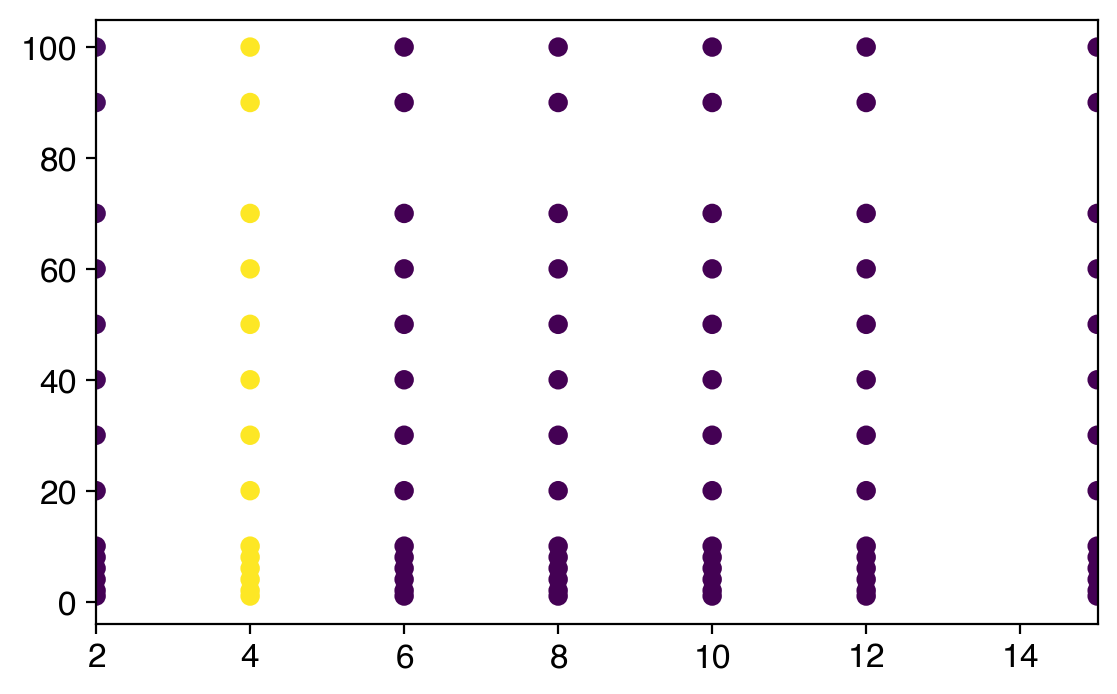

In [960]:
fig, ax = plt.subplots()
ax.scatter(df_lims["mass"], df_lims["ctau"], c=df_lims["obs"])

In [961]:
df_lims

,obs,exp_2.5,exp_16.0,exp_50.0,exp_84.0,exp_97.5,mass,ctau
name,,,,,,,,
mzd2_ctau100mm,209.271,105.176,148.013,224.375,358.530,558.352,2,100
mzd2_ctau10mm,30.433,15.161,21.336,32.344,51.424,80.388,2,10
mzd2_ctau1mm,41.851,20.226,27.888,41.094,62.879,94.162,2,1
mzd2_ctau50mm,112.168,56.250,78.662,120.000,190.792,298.251,2,50
mzd2_ctau90mm,189.164,95.215,133.152,203.125,324.575,505.472,2,90
...,...,...,...,...,...,...,...,...
mzd15_ctau20mm,1.492,0.415,0.736,1.416,2.759,4.294,15,20
mzd15_ctau8mm,1.241,0.350,0.611,1.147,2.181,3.479,15,8
mzd15_ctau6mm,1.270,0.362,0.623,1.157,2.172,3.508,15,6


Text(0.5, 1.0, 'Expected UL for $\\sigma$(H$\\rightarrow\\mathrm{Z_d Z_d}\\rightarrow 2\\mu 2\\mathrm{X}$)')

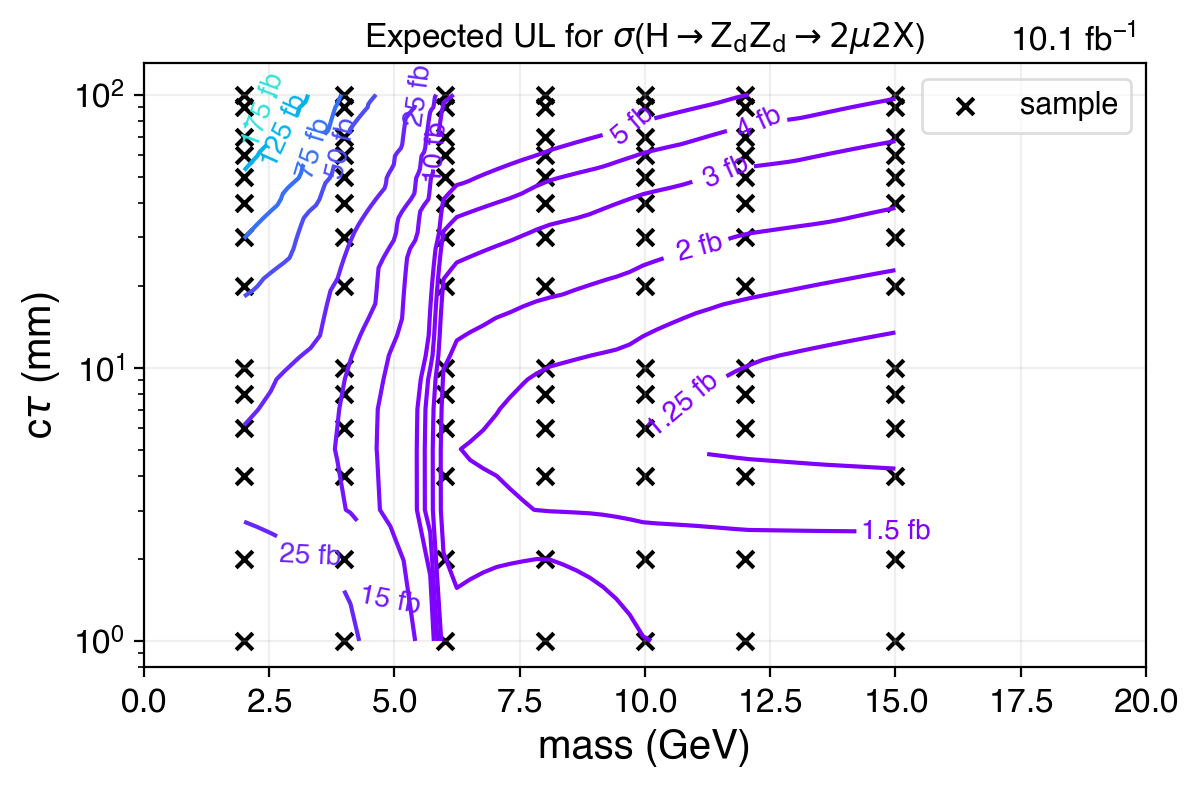

In [978]:
def grid(x, y, z, resX=50j, resY=50j):
    from scipy.interpolate import griddata
    xi, yi = np.mgrid[min(x):max(x):resX, min(y):max(y):resY]
    Z = griddata((x, y), z, (xi[None,:], yi[None,:]), method="linear") #, interp="linear")
#     Z = griddata((x, y), z, (xi[None,:], yi[None,:]), method="cubic", rescale=True) #, interp="linear")
    Z = Z[0]
    return xi, yi, Z

x = df_lims["mass"]
y = df_lims["ctau"]
zexp = df_lims["exp_50.0"]
zobs = df_lims["obs"]
X, Y, Zexp = grid(x,y,zexp)
_, _, Zobs = grid(x,y,zobs)

fig, ax = plt.subplots()
levels = [500,175, 125, 75, 50, 25, 15, 10, 5, 4, 3, 2, 1.5, 1.25][::-1]
# levels = np.logspace(np.log10(zexp.min()), np.log10(zexp.max()), 30)
# levels = 10
csexp = ax.contour(X, Y, Zexp, levels=levels, cmap="rainbow")
# csexp = ax.contour(X, Y, Zobs, levels=levels, cmap="rainbow")
ax.clabel(csexp, inline=1, fontsize=10, fmt="%2g fb")
ax.scatter(x, y, marker="x", color="k", label="sample")

ax.set_xlabel("mass (GeV)")
ax.set_ylabel(r"c$\tau$ (mm)")

ax.set_xlim([0,20])
# ax.set_ylim([0.,130])
ax.set_ylim([0.8,130])
# ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(alpha=0.2)
ax.legend()
ax.text(0.99, 1.01,"10.1 fb${}^\mathregular{-1}$", horizontalalignment='right', verticalalignment='bottom', transform = ax.transAxes, size="large")
ax.set_title(r"Expected UL for $\sigma$(H$\rightarrow\mathrm{Z_d Z_d}\rightarrow 2\mu 2\mathrm{X}$)")

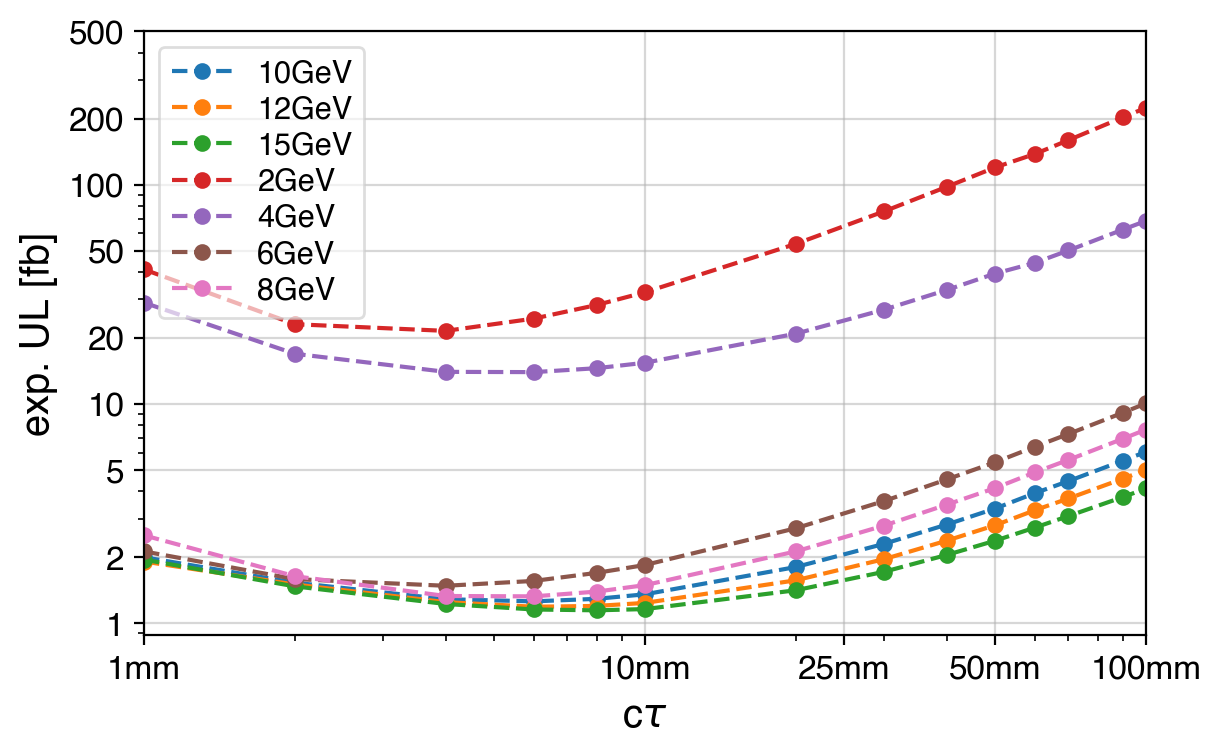

In [963]:
df = df_lims.sort_values("ctau")
df["smass"] = df["mass"].astype(str)+"GeV"
fig, ax = plt.subplots()
df.reset_index().set_index("ctau").groupby("smass")["exp_50.0"].plot(marker="o",linestyle="--",ms=5.0)
# df.reset_index().set_index("ctau").groupby("mass")["obs"].plot(marker="o")
ax.legend()
ax.set_yscale("log")
ax.set_xscale("log")
xticks = [1,10,25,50,100]
plt.xticks(xticks,["{}mm".format(x) for x in xticks])
yticks = [1,2,5,10,20,50,100,200,500]
plt.yticks(yticks,yticks)
ax.set_xlabel(r"c$\tau$")
ax.set_ylabel("exp. UL [fb]")
ax.grid(alpha=0.5)

In [790]:
df = pd.DataFrame([dict(name=name,count=df["weight"].sum()) for name,df in dfs_mc.items()])
df["mass"] = df["name"].map(lambda x:x.split("mzd")[1].split("_")[0]).astype(int)
masses = df["mass"].unique().tolist()
df["ctau"] = df["name"].map(lambda x:x.split("ctau")[1].split("mm")[0]).astype(int)
ctaus = df["ctau"].unique().tolist()
df

,name,count,mass,ctau
0,mzd10_ctau100mm,3.434000,10,100
1,mzd10_ctau10mm,21.260500,10,10
2,mzd10_ctau125mm,2.917778,10,125
3,mzd10_ctau1mm,26.805400,10,1
4,mzd10_ctau25mm,13.197333,10,25
...,...,...,...,...
59,mzd8_ctau1mm,24.896500,8,1
60,mzd8_ctau25mm,10.226250,8,25
61,mzd8_ctau50mm,5.630750,8,50
62,mzd8_ctau5mm,22.280600,8,5


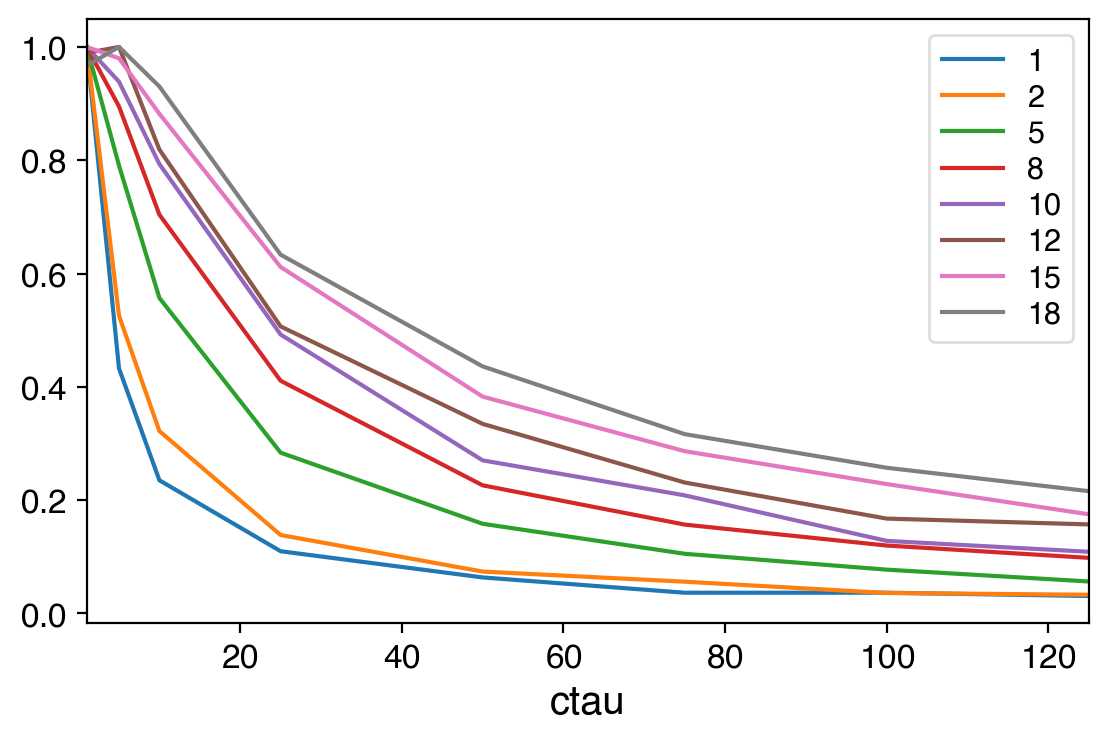

In [807]:
fig, ax = plt.subplots()
for mass, group in df.set_index("ctau").sort_index().groupby("mass"):
    c = group["count"]
    (c/c.max()).plot(ax=ax,label=mass)
ax.legend()
# ax.set_xscale("log")
# ax.set_yscale("log")

ctau
1      0.966583
5      1.000000
10     0.930075
25     0.633250
50     0.436090
75     0.316541
100    0.257143
125    0.215897
Name: count, dtype: float64